In [6]:
### 주제: "산불 확산 패턴을 통한 피해 면적 예측 프로젝트"
# 핵심 키워드 정리
# 산불 확산 패턴 - 산불의 이동 및 확산 경로 분석
# 피해 면적 예측 - 산불로 인한 최종 피해 면적(km²)을 수치로 예측
# 위성 데이터 - NASA FIRMS(산불)와 POWER API(기상) 활용
# 머신러닝 모델	회귀 분석 기반 피해 예측 모델 개발

### 대략적 일정
## 1일차 (월요일)
# 오전 (4h): NASA FIRMS 데이터 수집 → 4명 분담: 위도/경도, brightness 등 확인 (pandas.read_csv)
#          : SUOMI VIIRS C2(VNP14IMG) + J1 VIIRS C2(VJ114IMG) 데이터 수집 → 위도/경도, FRP 확인.
# 오후 (4h): NASA POWER API 다운로드 → 기온, 풍속, 습도 체크 후 병합 시작 (pd.merge)
#          : NASA POWER API 기상 데이터 병합 → 기온, 풍속 등 체크.
# 화요일 대비 - GeoJSON 데이터 찾아보고 없으면 shapely(시각화에서 활용되는 라이브러리(사실 나도 잘 모름...))으로 다각형 생성 준비
# MODIS C6.1도 과거 참고용으로 다운로드 시작

## 2일차 (화요일)
# 오전 (4h): 데이터 전처리 → 결측치(평균값), 이상치 제거 (IQR)
# 오후 (4h): 탐색적 데이터 분석(EDA) + Folium → 상관관계 분석 (seaborn) 후 VIIRS C2로 산불 위치 맵 생성 (folium.Marker).
# Folium 사용 이유:
# 패턴 파악: 산불 분포를 지도로 시각화해 지역별 확산 경향 조기 확인
# 발표 준비: PPT용 기초 지도를 만들어 5일차 부담 줄임
# GPT 팁! - heatmap으로 brightness 강도 추가하면 패턴 더 선명해짐!

## 3일차 (수요일)
# 오전 (4h): 초기 모델 구축 → 선형 회귀, Ridge, Lasso 학습 (scikit-learn), RMSE/MAE 계산
# 오후 (4h): 피처 엔지니어링 → 풍속습도, 온도강수량 등 추가, 그래프 분석 (Folium 생략)
# 피처 엔지니어링 요약
#  - 데이터를 더 똑똑하게 가공해서 모델 성능 높이는 작업
#  - 풍속*습도, 고온 여부 등 산불 피해와 관련성 높은 변수 생성
#  - VIIRS의 FRP 활용해 피해 강도 변수 만들어보기

# 4일차 (목요일)
# 오전 (4h): 모델 개선 → Random Forest, XGBoost 등 추가 학습 및 튜닝 (GridSearchCV)
# 오후 (4h): 결과 분석 + Folium → VIIRS C2 최적 모델의 예측 피해 면적(km²)을 색상 원으로 맵에 추가 (folium.Circle)
# Folium 사용 이유: 최종 예측 결과를 시각화해 발표용 핵심 자료 완성, 모델별 성능 비교 가능
# 최고 모델의 예측만 빨간색으로 표시하면 시각적 임팩트 추가하기
# MODIS C6.1 예측과 비교 슬라이드 넣으면 깊이 추가

# 5일차 (금요일)
# 오전 (4h): PPT 완성 → Folium(VIIRS C2) 지도 2개(위치, 예측)와 모델 성능 표 삽입.
# 오후 (4h): 완성 되지 못한 부분 보완 및 PPT 발표 대본 및 연습


# PPT 구성
# 표지: "산불 피해 예측 프로젝트" – 팀명
# 소개: 산불 피해의 심각성 (통계 그래프).
# 데이터: NASA FIRMS + POWER API 개요, Folium 산불 위치 맵
# 방법: 전처리 → 다중 회귀 모델 → 검증 다이어그램
# 모델 비교: 선형 회귀, Random Forest 등 RMSE/MAE 표
# 결과: 예측 면적(km²) + Folium 피해 범위 맵 (4일차), 최적 모델 성능
# 결론: 기대 효과와 확장 가능성 (예: 실시간 예측)

###
# SUOMI VIIRS C2: 최신, 고해상도 산불 데이터의 주력
# J1 VIIRS C2   : SUOMI와 짝꿍으로 더 촘촘한 관측
# MODIS C6.1    : 과거를 돌아보는 데 유용한 백업

### SUOMI VIIRS C2 (Suomi NPP VIIRS Collection 2)
# SUOMI VIIRS는 Suomi National Polar-orbiting Partnership (Suomi NPP)라는 위성에 탑재된 VIIRS(Visible Infrared Imaging Radiometer Suite) 센서에서 나온 데이터
# 특징:
#  - 해상도     : 375m (산불 탐지에 더 세밀함).
#  - 관측 시간  : 하루에 오전 1:30쯤과 오후 1:30쯤, 지구를 두 번 커버
#  - 업데이트   : 최신 알고리즘으로 데이터를 재처리해서 더 정확함.
#  - 산불 데이터: NASA FIRMS에서 제공하는 "VNP14IMG"라는 이름으로 산불 위치와 강도(FRP: Fire Radiative Power)를 탐지
#  - 쉽게 말하면: Suomi NPP라는 위성이 찍은 최신 산불 사진첩

# J1 VIIRS C2 (NOAA-20 VIIRS Collection 2)
# J1 VIIRS는 NOAA-20 위성(원래 이름은 JPSS-1)에 탑재된 VIIRS 센서 데이터
# 특징:
#  - 해상도: SUOMI VIIRS와 동일한 375m.
#  - 관측 시간: 오전 2:20쯤과 오후 2:20쯤으로, SUOMI보다 50분 뒤에 지나감.
#  - 목적: SUOMI와 비슷하지만, 더 자주 관측해서 데이터 빈틈을 줄임.
#  - 산불 데이터: "VJ114IMG"라는 이름으로 FIRMS에서 제공. SUOMI와 거의 똑같은 정보를 주지만, 시간 차이 때문에 보완적인 역할.
#  - 쉽게 말하면: NOAA-20 위성이 SUOMI의 동생처럼 뒤따라가며 찍은 산불 사진첩

# MODIS C6.1 (MODIS Collection 6.1)
# MODIS는 Terra와 Aqua라는 두 위성에 탑재된 Moderate Resolution Imaging Spectroradiometer 센서의 데이터야. "C6.1"은 Collection 6.1, 즉 6번째 버전의 업데이트판.
# 특징:
# 해상도: 1km (VIIRS보다 덜 세밀함).
# 관측 시간: Terra는 오전 10:30쯤, Aqua는 오후 1:30쯤 지나감.
# 역사: 2000년대 초반부터 데이터를 쌓아왔으니 더 긴 시간 기록을 볼 수 있음.
# 산불 데이터: "MCD14"라는 이름으로 FIRMS에서 제공. 산불 위치와 FRP를 탐지하지만, 해상도가 낮아서 작은 불은 놓칠 수 있어.
# 쉽게 말하면: 오래된 형님 위성이 찍은 산불 사진첩의 6.1번째 버전이야. 좀 더 흐릿하지만 오래된 이야기를 들려줘!

# 차이점        비교
# 항목          SUOMI VIIRS C2      J1 VIIRS C2         MODIS C6.1
# 위성          Suomi NPP           NOAA-20 (JPSS-1)    Terra & Aqua
# 센서          VIIRS               VIIRS               MODIS
# 해상도        375m                375m                1km
# 관측 시간     1:30 AM/PM          2:20 AM/PM          10:30 AM, 1:30 PM
# 버전          Collection 2        Collection 2        Collection 6.1
# 장점          세밀하고 최신       SUOMI와 보완        긴 시간 기록
# 단점          짧은 역사           짧은 역사           덜 세밀함
# FIRMS 이름    VNP14IMG            VJ114IMG            MCD14

# SUOMI VIIRS C2와 J1 VIIRS C2: 최신이고 해상도가 높아서 산불 위치와 피해 면적 예측에 더 정확. 특히 375m 해상도는 작은 불도 잡아내니까 EDA와 Folium 시각화에 딱!
# MODIS C6.1: 과거 데이터(20년 이상)를 보고 싶을 때 유용해. 예를 들어, "과거 산불 패턴이 지금이랑 얼마나 달라졌나?" 같은 분석에 쓰면 좋음.
# 추천: 프로젝트에선 주로 VIIRS C2(SUOMI + J1)를 쓰고, 필요하면 MODIS C6.1로 과거 비교

In [7]:
### 1. 산불 데이터 (fire_data)
# 필수 데이터 (NASA FIRMS 활용)
# fire_id	    str	        산불 고유 ID
# latitude	    float	    위도
# longitude	    float	    경도
# date	        str	        관측 날짜 (YYYY-MM-DD)
# brightness	float	    화재 밝기 지수 (K)
# confidence	int	        신뢰도 (0~100)
# frp	        float	    화재 방출력 (MW)

### 2. 기상 데이터 (weather_data)
# 필수 데이터 (NASA POWER API 활용)
# latitude	    float	    위도
# longitude	    float	    경도
# date	        str	        기상 데이터 날짜 (YYYY-MM-DD)
# temperature	float	    기온 (°C)
# humidity	    float	    상대 습도 (%)
# wind_speed	float	    풍속 (m/s)
# precipitation	float	    강수량 (mm)

### 3. 산불 확산 경계 데이터 (geojson_data)
# region_name	str	        지역명 (ex: California)
# geometry	    dict	    GeoJSON 형식의 다각형 좌표
# fire_count	int	        해당 지역에서 발생한 산불 수

# 산불 경계 데이터 (GeoJSON)
# GeoJSON을 찾아봐야 할 곳
# Global Fire Atlas: https://www.globalfiredata.org
# NASA FIRMS (GIS Data): https://firms.modaps.eosdis.nasa.gov/gisdata/
# OpenStreetMap Wildfire Data: https://overpass-turbo.eu
# 없으면 산불데이터로 형성 (open ai 질문 결과 shapely 라이브러리 활용, 산불 데이터 (latitude, longitude)를 Convex Hull 알고리즘을 이용해 다각형(Polygon)으로 변환

### 4. 예측 피해 면적 데이터 (pred_data)
# latitude	    float	    예측된 피해 중심 위도
# longitude	    float	    예측된 피해 중심 경도
# pred_area	    float	    예측된 피해 면적 (km²)
# confidence	float	    예측 신뢰도 (0~1)

# 공통 사용 데이터 변수명
# fire_data: NASA FIRMS 데이터
# weather_data: NASA POWER API 기상 데이터
# geojson_data: 산불 확산 경계 데이터 (GeoJSON)
# pred_data: 머신러닝 모델의 예측 결과

### 필요할거로 예상되는 파일 구조
# wildfire_project/
# - data/
#   - fire_data.csv  # NASA FIRMS 데이터
#   - weather_data.csv  # NASA POWER API 데이터
#   - fire_boundary.geojson  # 산불 확산 경계 (GeoJSON) (없으면 위도 경도 직접 활용해서 사용)

# - models/
#   - 우리가 배운 회귀 모델들 사용 후 선정 할 파일
#     (클래스로 만들어서 데이터 프레임으로 하거나 모델별로 파일 생성.) - 상의 후 결정

# - visualizations/
#   - fire_map.html  # Folium 지도 (산불 위치)
#   - fire_heatmap.html  # Folium 히트맵 (산불 강도)

# - main.ipynb  # 분석 코드
# - presentation.pptx  # 최종 발표 자료

In [8]:
# SUOMI VIIRS C2 (VNP14IMG): 해상도 375m로 세밀한 관측이 가능하고 최신 알고리즘으로 처리된 데이터입니다.# J1 VIIRS C2 (VJ114IMG): 해상도 375m로 비슷하지만, SUOMI VIIRS C2와 시간 차이로 보완적인 역할을 합니다.
# 추천 방법
# 주요 분석이 실시간 산불 확산을 추적하고 예측하는 것이라면 실시간 데이터를 사용하세요.
# 과거 데이터를 사용할 경우, SUOMI VIIRS C2 (wildfire_aS1_df)와 J1 VIIRS C2 (wildfire_aJ1_df)를 비교하고 분석할 수 있습니다.
# 따라서 실시간 산불 확산 추적과 피해 면적 예측이 주 목표라면, wildfire_nS1_df (SUOMI VIIRS C2 실시간 데이터)와 wildfire_nJ1_df (J1 VIIRS C2 실시간 데이터)를 주로 사용할 수 있습니다.

# 데이터 병합에 대한 참고
# 병합 기준: 위도, 경도, 시간을 기준으로 데이터를 병합합니다. 이 두 데이터 세트를 병합하여, 실시간 산불 정보와 기상 데이터를 통합해 예측 모델을 구성하는 방식으로 진행할 수 있습니다.

# 예시 병합 코드:

# python
# 복사
# # 예시: 실시간 산불 데이터와 날씨 데이터 병합
# import pandas as pd

# # 산불 데이터 (실시간)
# wildfire_data = pd.concat([wildfire_nS1_df, wildfire_nJ1_df])

# # 기상 데이터 (POWER API에서 가져온 기온, 풍속, 습도 데이터)
# weather_data = pd.read_csv("power_api_data.csv")ㅁ

# # 날짜 및 위치를 기준으로 병합
# merged_data = pd.merge(wildfire_data, weather_data, on=["latitude", "longitude", "time"], how="inner")

# print(merged_data.head())
# 이렇게 실시간 산불 데이터와 기상 데이터를 병합하여, 이후 피해 면적 예측을 위한 모델링에 사용할 수 있습니다.

# 결론
# 실시간 산불 데이터인 wildfire_nS1_df와 wildfire_nJ1_df를 사용하되, 과거 데이터를 활용하여 패턴 분석을 원한다면 wildfire_aS1_df와 wildfire_aJ1_df를 비교하는 방식으로 진행할 수 있습니다.

# 기상 데이터와의 병합은 위도, 경도, 시간을 기준으로 진행하면 됩니다.

# 선택하신 데이터에 따라, 그에 맞는 분석을 진행하시면 됩니다! 추가적인 도움이 필요하면 언제든지 말씀해 주세요.



In [4]:
import requests

# 기상 데이터 요청할 지역 (위도, 경도)
latitude = 36.7783  # 캘리포니아 근처
longitude = -119.4179

# 요청할 기간 (2015년 1월 1일 ~ 2025년 2월 28일)
start_date = "20150101"
end_date = "20250228"

# API 요청 URL
url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,WS2M,RH2M,PRECTOTCORR&community=AG&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format=CSV"

# API 요청 보내기
response = requests.get(url)

# 파일 저장
if response.status_code == 200:
    with open("weather_data.csv", "w") as file:
        file.write(response.text)
    print("✅ 기상 데이터 다운로드 완료! (weather_data.csv)")
else:
    print("❌ 데이터 요청 실패!", response.status_code)


✅ 기상 데이터 다운로드 완료! (weather_data.csv)


### 라이브러리 정의

In [1]:
import pandas as pd

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns

### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

### 데이터 불러오기

In [ ]:
# 1. 산불 데이터 로드
wildfire_dfs = {
    'aS1': pd.read_csv("./USA data/fire_archive_SV-C2_589630.csv"),
    'nS1': pd.read_csv("./USA data/fire_nrt_SV-C2_589630.csv"),
    'aJ1': pd.read_csv("./USA data/fire_archive_J1V-C2_589629.csv"),
    'nJ1': pd.read_csv("./USA data/fire_nrt_J1V-C2_589629.csv")
}

# 2. 날씨 데이터 로드 및 timestamp 변환
weather_df = pd.read_csv("./USA data/weather_data.csv")
weather_df["acq_date"] = pd.to_datetime(weather_df["YEAR"].astype(str) + weather_df["DOY"].astype(str), format="%Y%j")

# 3. 데이터 정보 확인
for name, df in wildfire_dfs.items():
    print(f"\n{name} 데이터:")
    print(df.info())
print("\n날씨 데이터:")
print(weather_df.info())

# 4. 데이터 샘플 확인
for name, df in wildfire_dfs.items():
    print(f"\n{name} 데이터 샘플:")
    print(df.head())
print("\n날씨 데이터 샘플:")
print(weather_df.head())

# 5. 산불 데이터의 acq_date 열을 datetime으로 변환
for df in wildfire_dfs.values():
    df["acq_date"] = pd.to_datetime(df["acq_date"])  # acq_date 열을 datetime으로 변환

# 산불 데이터 합치기
wildfire_df = pd.concat(wildfire_dfs.values())

# 6. 데이터 병합 및 저장
# 날씨 데이터도 acq_date를 datetime으로 변환
weather_df["acq_date"] = pd.to_datetime(weather_df["acq_date"])

# 병합하기
merged_df = pd.merge(wildfire_df, weather_df, on="acq_date", how="left")

# 병합된 데이터 정보 출력
print("\n병합된 데이터 정보:")
print(merged_df.info())
print(merged_df.head(2))

# acq_date와 acq_time을 결합하여 새로운 datetime 컬럼 생성
merged_df["datetime"] = pd.to_datetime(
    merged_df["acq_date"].astype(str) + " " + merged_df["acq_time"].astype(str).str.zfill(4), 
    format="%Y-%m-%d %H%M"
)

# 2025년 3월 01일 이후의 행 삭제
cutoff_date = pd.Timestamp("2025-03-01")  # 기준 날짜 설정
merged_df = merged_df[merged_df["datetime"] <= cutoff_date]  # 2025년 2월 28일 이후의 행 삭제

# 결과 확인
print(merged_df[["acq_date", "datetime"]].head())

# 'YEAR', 'DOY', 'acq_time' : datetime 컬럼 추가 예정으로 컬럼 중복 삭제
merged_df.drop(columns=["acq_time", "YEAR", "DOY"], inplace=True)

# 저장 (필요한 경우)
merged_df.to_csv("./USA data/merged_wildfire_weather.csv", index=False)


aS1 데이터:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5362143 entries, 0 to 5362142
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   latitude    float64
 1   longitude   float64
 2   brightness  float64
 3   scan        float64
 4   track       float64
 5   acq_date    object 
 6   acq_time    int64  
 7   satellite   object 
 8   instrument  object 
 9   confidence  object 
 10  version     int64  
 11  bright_t31  float64
 12  frp         float64
 13  daynight    object 
 14  type        int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 613.6+ MB
None

nS1 데이터:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76214 entries, 0 to 76213
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    76214 non-null  float64
 1   longitude   76214 non-null  float64
 2   brightness  76214 non-null  float64
 3   scan        76214 non-null  float64
 4   track       7

### 통합데이터 불러들이기

In [10]:
merged_wildfire_df = pd.read_csv("./USA data/merged_wildfire_weather.csv")
merged_wildfire_df.info()
merged_wildfire_df.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1352\2052729770.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_wildfire_df = pd.read_csv("./USA data/merged_wildfire_weather.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9179063 entries, 0 to 9179062
Data columns (total 19 columns):
 #   Column       Dtype  
---  ------       -----  
 0   latitude     float64
 1   longitude    float64
 2   brightness   float64
 3   scan         float64
 4   track        float64
 5   acq_date     object 
 6   satellite    object 
 7   instrument   object 
 8   confidence   object 
 9   version      object 
 10  bright_t31   float64
 11  frp          float64
 12  daynight     object 
 13  type         float64
 14  T2M          float64
 15  WS2M         float64
 16  RH2M         float64
 17  PRECTOTCORR  float64
 18  datetime     object 
dtypes: float64(12), object(7)
memory usage: 1.3+ GB


,latitude,longitude,brightness,scan,track,acq_date,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,T2M,WS2M,RH2M,PRECTOTCORR,datetime
0,40.12655,-80.99725,322.99,0.42,0.61,2015-01-01,N,VIIRS,n,2,265.48,3.25,N,0.0,1.23,0.66,43.37,0.0,2015-01-01 06:33:00
1,40.75163,-81.44097,335.90,0.45,0.63,2015-01-01,N,VIIRS,n,2,264.78,3.97,N,0.0,1.23,0.66,43.37,0.0,2015-01-01 06:33:00
2,39.93786,-76.81354,301.80,0.51,0.49,2015-01-01,N,VIIRS,n,2,267.25,0.80,N,2.0,1.23,0.66,43.37,0.0,2015-01-01 06:33:00
3,37.23229,-82.03670,295.38,0.46,0.64,2015-01-01,N,VIIRS,n,2,268.12,0.83,N,2.0,1.23,0.66,43.37,0.0,2015-01-01 06:34:00
4,36.35398,-76.80887,301.27,0.46,0.47,2015-01-01,N,VIIRS,n,2,272.02,1.35,N,2.0,1.23,0.66,43.37,0.0,2015-01-01 06:34:00


In [11]:
### Datetime 형식변환
merged_wildfire_df['datetime'] = pd.to_datetime(merged_wildfire_df['datetime'])

### 데이터 전처리

##### 결측데이터 처리

In [12]:
### merged_df DataFrame의 모든 컬럼들의 결측 빈도 확인하기
merged_wildfire_df.isnull().sum(axis=0)

latitude            0
longitude           0
brightness          0
scan                0
track               0
acq_date            0
satellite           0
instrument          0
confidence          0
version             0
bright_t31          0
frp                 0
daynight            0
type           115159
T2M                 0
WS2M                0
RH2M                0
PRECTOTCORR         0
datetime            0
dtype: int64

In [13]:
### 결측치가 있고 무의미하다고 판단되는 컬럼 삭제
### 결측치가 있는 컬럼 자체 삭제
columns_to_drop = [
    'scan',            # 데이터 스캔 번호, 예측과 직접적인 관련이 적음
    'track',           # 추적 번호, 예측과 직접적인 관련이 적음
    'satellite',       # 산불 관측 위성 정보, 예측과 관련이 적음
    'instrument',      # 사용된 센서 종류, 예측에 큰 영향을 미치지 않음
    'version',         # 데이터 버전 정보, 예측과 관련 없음
    'type'             # 산불 유형, 예측 모델과 직접적인 관계가 없음
]

# 불필요한 컬럼 제거
merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)
merged_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9179063 entries, 0 to 9179062
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   latitude     float64       
 1   longitude    float64       
 2   brightness   float64       
 3   acq_date     object        
 4   confidence   object        
 5   bright_t31   float64       
 6   frp          float64       
 7   daynight     object        
 8   T2M          float64       
 9   WS2M         float64       
 10  RH2M         float64       
 11  PRECTOTCORR  float64       
 12  datetime     datetime64[ns]
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 910.4+ MB


In [14]:
### merged_df DataFrame의 모든 컬럼들의 결측 빈도 확인하기
merged_wildfire_df.isnull().sum(axis=0)

latitude       0
longitude      0
brightness     0
acq_date       0
confidence     0
bright_t31     0
frp            0
daynight       0
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
datetime       0
dtype: int64

##### 이상데이터처리

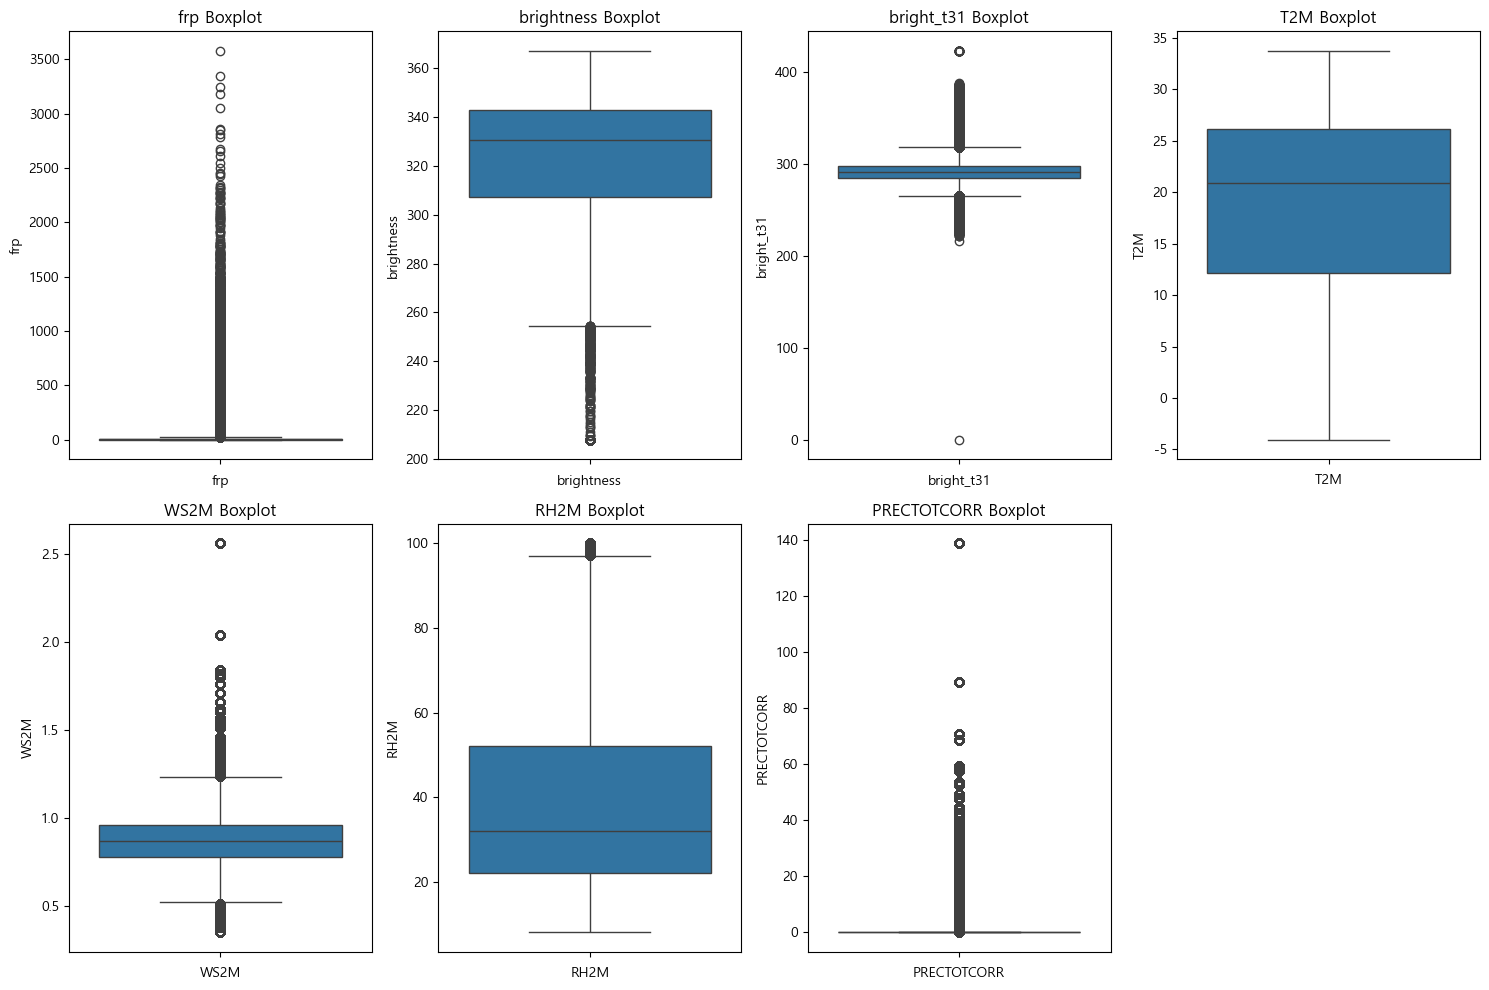

In [7]:
# 여러 변수에 대해 boxplot을 한 번에 그리기
plt.figure(figsize=(15, 10))

# 각 변수에 대해 Boxplot 생성
variables = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for i, v in enumerate(variables, 1):
    plt.subplot(2, 4, i) # 2행 4열
    sns.boxplot(merged_wildfire_df[v])
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()

### 해석
# 1. frp Boxplot (Fire Radiative Power)
# 이상치: 500에서 3500 사이에 여러 점이 흩어져 있음. 
#         이는 극단적으로 높은 frp 값을 가진 몇 가지 관측치를 의미할 수 있음 (예: 대규모 산불).
# 해석: 대부분의 산불은 낮은 방사 에너지를 가지지만, 드물게 매우 강한 산불이 발생할 수 있음.

# 2. brightness Boxplot (밝기)
# 이상치: 250미만의 수들
# 해석: 밝기 값은 대체로 일정하지만, 일부 관측치가 약간 더 어두운 밝기를 가짐. 이는 센서 감도나 특정 조건(예: 낮 시간 대형 화재)에 의한 것일 수 있음.

# 3. bright_t31 Boxplot
# 이상치: 300 이상에 몇 개의 점이 있음.
# 해석: bright_t31(31번째 채널의 밝기)은 약간 더 넓은 분포를 보이며, 일부 높은 값이 이상치로 나타남. 이는 특정 환경(예: 구름이나 연기)에 영향을 받을 수 있음.

# 4. TZM Boxplot (2m 높이 기온)
# 이상치: 거의 없음.
# 해석: 기온 데이터는 비교적 균일하며, 산불 발생 시 평균 기온이 15~20도 사이인 경우가 많음을 시사. 극단적인 이상치는 드물음.

# 5. WS2M Boxplot (2m 높이 풍속)
# 이상치: 약 5 이상에 몇 개의 점이 있음.
# 해석: 풍속은 대체로 낮지만, 일부 지역에서 높은 풍속(이상치)이 산불 확산에 기여했을 가능성이 있음.

# 6. RH2M Boxplot (2m 높이 상대습도)
# 이상치: 약 100 이상에 몇 개의 점이 있음 (습도가 100%를 초과하는 것은 측정 오류 가능성).
# 해석: 상대습도는 다양하며, 산불 발생 시 습도가 40~80% 사이인 경우가 많음. 이상치는 데이터 정제가 필요할 수 있음.

# 7. PRECTOTCORR Boxplot (교정된 총 강수량)
# 이상치: 100~140 사이에 몇 개의 점이 있음.
# 해석: 대부분의 산불 발생 시 강수량은 거의 없었으나, 
#       드물게 높은 강수량이 기록됨. 이는 산불이 발생한 후 소화된 경우일 수 있음.

# 종합 해석:
# 분포 특징: 대부분의 변수(특히 frp, PRECTOTCORR)는 중앙값이 낮고 이상치가 두드러짐. 
#            이는 산불 데이터가 극단적인 사건에 의해 영향을 받는 경향이 있음을 보여줌.
# 환경 요인: WS2M(풍속)과 RH2M(상대습도)는 약간의 변동성을 보이며, 산불 확산에 중요한 역할을 할 수 있음. TZM(기온)은 비교적 안정적.
# 데이터 정제 필요성: 일부 이상치(예: RH2M > 100%, PRECTOTCORR > 100)는 측정 오류나 비정상적인 조건일 수 있으니 검토가 필요.

In [15]:
### 습도 이상치 갯수 확인
(merged_wildfire_df["RH2M"] >= 100).value_counts()

RH2M
False    9178172
True         891
Name: count, dtype: int64

count    9.179063e+06
mean     9.384961e-01
std      4.499746e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e-02
max      1.000000e+02
Name: PRECTOTCORR, dtype: float64
count    9.179063e+06
mean     3.892475e+01
std      2.103636e+01
min      8.070000e+00
25%      2.202000e+01
50%      3.191000e+01
75%      5.208000e+01
max      1.000000e+02
Name: RH2M, dtype: float64


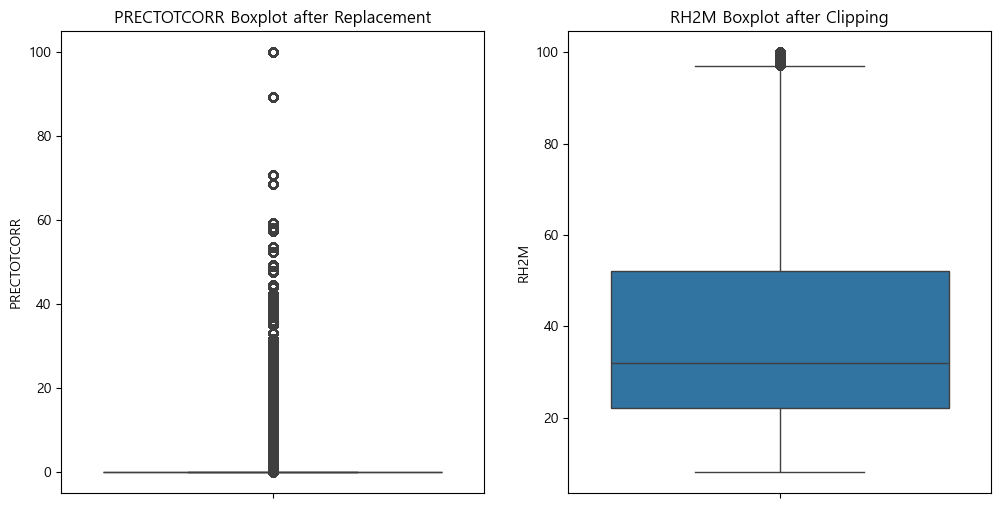

In [22]:
# 1. PRECTOTCORR 140mm 대체
merged_wildfire_df.loc[merged_wildfire_df['PRECTOTCORR'] > 100, 'PRECTOTCORR'] = 100

# 2. RH2M 100% 초과 값 클리핑
merged_wildfire_df.loc[merged_wildfire_df['RH2M'] > 100, 'RH2M'] = 100


# 결과 확인
print(merged_wildfire_df['PRECTOTCORR'].describe())
print(merged_wildfire_df['RH2M'].describe())

# 선택적: 박스플롯으로 처리 결과 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(merged_wildfire_df['PRECTOTCORR'])
plt.title("PRECTOTCORR Boxplot after Replacement")

plt.subplot(1, 2, 2)
sns.boxplot(merged_wildfire_df['RH2M'])
plt.title("RH2M Boxplot after Clipping")
plt.show()

In [23]:
# IQR 계산 함수
def calculate_iqr(df, columns):
    iqr_results = {}
    for col in columns:
        # Q1와 Q3 계산
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # IQR 계산
        IQR = Q3 - Q1
        
        # 이상치 기준 설정
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 찾기
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        # 결과 저장
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

columns_to_check = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
iqr_results = calculate_iqr(merged_wildfire_df, columns_to_check)

# 결과 확인
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")

Column: frp
  Q1: 1.65
  Q3: 9.42
  IQR: 7.77
  Lower Bound: -10.004999999999999
  Upper Bound: 21.075
  Outliers Count: 1053868

Column: brightness
  Q1: 307.4
  Q3: 342.71
  IQR: 35.31
  Lower Bound: 254.43499999999997
  Upper Bound: 395.67499999999995
  Outliers Count: 8139

Column: bright_t31
  Q1: 285.04
  Q3: 298.4
  IQR: 13.359999999999957
  Lower Bound: 265.0000000000001
  Upper Bound: 318.43999999999994
  Outliers Count: 282682

Column: T2M
  Q1: 12.19
  Q3: 26.14
  IQR: 13.950000000000001
  Lower Bound: -8.735000000000001
  Upper Bound: 47.065
  Outliers Count: 0

Column: WS2M
  Q1: 0.78
  Q3: 0.96
  IQR: 0.17999999999999994
  Lower Bound: 0.5100000000000001
  Upper Bound: 1.23
  Outliers Count: 209072

Column: RH2M
  Q1: 22.02
  Q3: 52.08
  IQR: 30.06
  Lower Bound: -23.069999999999997
  Upper Bound: 97.16999999999999
  Outliers Count: 46886

Column: PRECTOTCORR
  Q1: 0.0
  Q3: 0.04
  IQR: 0.04
  Lower Bound: -0.06
  Upper Bound: 0.1
  Outliers Count: 1822330

